In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import tensorflow as tf
import DifferentiableHOS as DHOS

Populating the interactive namespace from numpy and matplotlib


In [2]:
kmap=pickle.load(open('/global/cscratch1/sd/dlan/maps/maps/res_maps_0_0', 'rb'))
k_map=kmap['kmap']

In [3]:
l1norm=DHOS.statistics.l1norm(k_map)
non_diffable_l1norm=DHOS.statistics.non_diffable_l1norm(k_map)

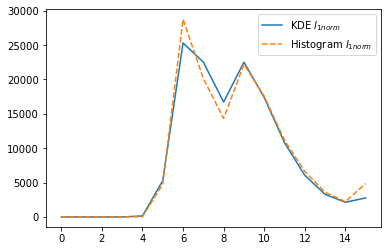

In [4]:
plot(l1norm[-1],label='KDE $l_{1norm}$')
plot(non_diffable_l1norm[-1][0],'--', label='Histogram $l_{1norm}$')
legend()

In [5]:
l1norm_b=DHOS.statistics.l1norm(k_map,bw_factor=4.)

In [6]:
@tf.function
def func(kmap):
    kmap=tf.cast(kmap,dtype=tf.float32)
    l1norm=DHOS.statistics.l1norm(tf.reshape(kmap, [1,64,64]),nscales=4,nbins=10, value_range=[-0.05, 0.05])[1]
    l1norm=tf.reduce_sum(l1norm**2)
    return l1norm

@tf.function
def compute_gradient_diff(kmap):
  """ Function that actually computes the Jacobian of a given statistics
  """
  kmap = tf.convert_to_tensor(kmap, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(kmap)
    l1norm = func(kmap)
  jac = tape.gradient(l1norm,kmap)
  return jac

In [7]:
dl2_tf = compute_gradient_diff(k_map[:,:64,:64])

In [8]:
import numdifftools as nd
dl1=nd.Gradient(func)
dl1_np=dl1(k_map[:,:64,:64])

Text(0.5, 1.0, 'residuals')

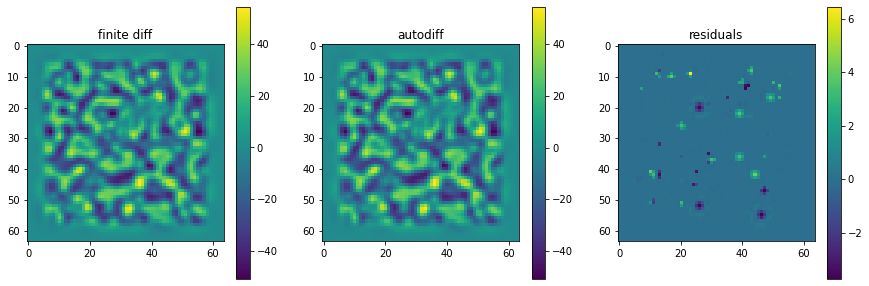

In [9]:
figure(figsize=[15,5])
subplot(131)
imshow(dl1_np.reshape([64,64]));colorbar()
title('finite diff')
subplot(132)
imshow((dl2_tf[0].numpy())); colorbar()
title('autodiff')
subplot(133)
imshow((dl2_tf[0].numpy())-dl1_np.reshape([64,64])); colorbar()
title('residuals')